# Biological Data Project

Group members:

- Alberto Calabrese

- Marlon Helbing

- Lorenzo Baietti

"A protein domain is a conserved part of a given protein sequence and tertiary structure that can evolve, function, and exist independently of the rest of the protein chain. Each domain forms a compact three-dimensional structure and often can be independently stable and folded." (Wikipedia).

The project is about the characterization of a single domain. Each group is provided with a representative domain sequence and the corresponding Pfam identifier (see table below). The objective of the project is to build a sequence model starting from the assigned sequence and to provide a functional characterization of the entire domain family (homologous proteins).

## Input
A representative sequence of the domain family. Columns are: group, UniProt accession, organism, Pfam identifier, Pfam name, domain position in the corresponding UniProt protein, domain sequence.

```
UniProt : P54315 
PfamID : PF00151 
Domain Position : 18-353 
Organism : Homo sapiens (Human) 
Pfam Name : Lipase/vitellogenin 
Domain Sequence : KEVCYEDLGCFSDTEPWGGTAIRPLKILPWSPEKIGTRFLLYTNENPNNFQILLLSDPSTIEASNFQMDRKTRFIIHGFIDKGDESWVTDMCKKLFEVEEVNCICVDWKKGSQATYTQAANNVRVVGAQVAQMLDILLTEYSYPPSKVHLIGHSLGAHVAGEAGSKTPGLSRITGLDPVEASFESTPEEVRLDPSDADFVDVIHTDAAPLIPFLGFGTNQQMGHLDFFPNGGESMPGCKKNALSQIVDLDGIWAGTRDFVACNHLRSYKYYLESILNPDGFAAYPCTSYKSFESDKCFPCPDQGCPQMGHYADKFAGRTSEEQQKFFLNTGEASNF
```

## Domain model definition
The objective of the first part of the project is to build a PSSM and HMM model representing the assigned domain. The two models will be generated starting from the assigned input sequence. The accuracy of the models will be evaluated against Pfam annotations as provided in the SwissProt database.

In [ ]:
from Bio import AlignIO
from collections import Counter
import pandas as pd
from scipy.stats import entropy
import math
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
import sys

In [ ]:
class ConservationAnalyzer:
    def __init__(self, alignment_file):
        """
        Initialize with an alignment file
            alignment_file (str): Path to the alignment file
        """
        self.alignment = AlignIO.read(alignment_file, 'fasta')
        self.num_sequences = len(self.alignment)
        self.alignment_length = self.alignment.get_alignment_length()
        
    def get_column(self, pos):
        """Extract a column from the alignment"""
        return [record.seq[pos] for record in self.alignment]
    
    def calculate_gap_frequency(self, pos):
        """Calculate frequency of gaps in a column"""
        column = self.get_column(pos)
        return column.count('-') / len(column)
    
    def calculate_amino_acid_frequencies(self, pos):
        """Calculate frequencies of each amino acid in a column"""
        column = self.get_column(pos)
        total = len(column) - column.count('-')  # Don't count gaps, such that when we calculate conservation scores the gaps don't mess it up 
        if total == 0:
            return {}
        
        counts = Counter(aa for aa in column if aa != '-')
        return {aa: count/total for aa, count in counts.items()}
    
    def calculate_conservation_score(self, pos):
        """
        Calculate conservation score based on frequency of most common amino acid
        Ignores gaps in calculation
        """
        freqs = self.calculate_amino_acid_frequencies(pos)
        if not freqs:
            return 0
        return max(freqs.values())
    
    def calculate_entropy(self, pos):
        """
        Calculate Shannon entropy for a column
        Lower entropy means higher conservation
        """
        freqs = self.calculate_amino_acid_frequencies(pos)
        if not freqs:
            return float('inf')  
        
        return -sum(p * math.log2(p) for p in freqs.values())
    
    def get_amino_acid_groups(self):
        """Define groups of similar amino acids 
           Based on : https://en.wikipedia.org/wiki/Conservative_replacement#:~:text=There%20are%2020%20naturally%20occurring,both%20small%2C%20negatively%20charged%20residues.
        """
        return {
            'aliphatic': set('GAVLI'),
            'hydroxyl': set('SCUTM'),
            'cyclic': set('P'),
            'aromatic': set('FYW'),
            'basic': set('HKR'),
            'acidic': set('DENQ')
        }
    
    def calculate_group_conservation(self, pos):
        """
        Calculate conservation considering amino acid groups
        Basically the same as calculate_conversation_score, just that it calculates based on the groups, not single amino acids !
        """
        column = self.get_column(pos)
        groups = self.get_amino_acid_groups()
        
        # Assign each amino acid to its group
        aa_to_group = {}
        for group_name, aas in groups.items():
            for aa in aas:
                aa_to_group[aa] = group_name
        
        # Count group occurrences
        group_counts = Counter(aa_to_group.get(aa, 'other') 
                             for aa in column if aa != '-')
        
        if not group_counts:
            return 0
            
        return max(group_counts.values()) / sum(group_counts.values())



    """
    def find_similar_sequences(self, similarity_threshold):
        # TODO : I think using JalView for this is better : JalView --> Edit --> Remove Redundancy 
        similar_pairs = []
        
        for i in range(len(self.alignment)):
            for j in range(i + 1, len(self.alignment)):
                seq1 = str(self.alignment[i].seq)
                seq2 = str(self.alignment[j].seq)
                
                # Calculate similarity (ignoring gaps)
                matches = sum(a == b for a, b in zip(seq1, seq2) if a != '-' and b != '-')
                total = sum(1 for a, b in zip(seq1, seq2) if a != '-' and b != '-')
                
                if total > 0:
                    similarity = matches / total
                    if similarity >= similarity_threshold:
                        similar_pairs.append((
                            self.alignment[i].id,
                            self.alignment[j].id,
                            similarity
                        ))
    
        return similar_pairs


    def analyze_rows(self, similarity_threshold = 0.95):
        similar_pairs = self.find_similar_sequences(similarity_threshold)
        print(f"We have {len(similar_pairs)} many pairs with {similarity_threshold} or more identity (excluding gaps) of a total of {self.num_sequences} sequences")
    """

    # TODO : I took very strict values now such that the number of residues per sequence is below 100 (right now we have length 77) ; the PSSM creation with 
    # much higher length did not work, but maybe we should write an email and ask ; nevertheless, we can first try some evaluation based on that PSSM and see our scores
    def analyze_columns(self, gap_threshold=0.37, conservation_threshold=0.9):
        """
        Analyze all columns and return comprehensive metrics
        Returns DataFrame with various conservation metrics for each position
        """
        data = []
        
        for i in range(self.alignment_length):
            gap_freq = self.calculate_gap_frequency(i)
            cons_score = self.calculate_conservation_score(i)
            info_content = self.calculate_entropy(i)
            group_cons = self.calculate_group_conservation(i)
            
            data.append({
                'position': i + 1,
                'gap_frequency': gap_freq,
                'single_conservation': cons_score,
                'entropy': info_content,
                'group_conservation': group_cons,
                # Here we should look possibly for better ideas
                # Check gap frequency not too high (i.e. not nearly all elements in the columns gaps (-))
                # Check that the group conservation is high enough (i.e. the amino acids are not too different
                # ; right now we do with groups and not single amino acid sequence since I'd say the groups
                # are more representative (if we do single amino acids, we'd delete more stuff))
                'suggested_remove': (gap_freq > gap_threshold or       
                                   group_cons < conservation_threshold)
            })
        
        return pd.DataFrame(data)

In [ ]:
def remove_columns_from_alignment(input_file, output_file, columns_to_remove, format="fasta"):
    """
    Remove specified columns from a multiple sequence alignment and save to new file
    
    Args:
        input_file (str): Path to input alignment file
        output_file (str): Path where to save trimmed alignment
        columns_to_remove (list): List of column indices to remove (0-based)
        format (str): File format (default: "fasta")
    """
    # Read the alignment
    alignment = AlignIO.read(input_file, format)
    
    # Sort columns to remove in descending order
    # (so removing them doesn't affect the indices of remaining columns)
    columns_to_remove = sorted(columns_to_remove, reverse=True)
    
    # Create new alignment records
    new_records = []
    
    # Process each sequence
    for record in alignment:
        # Convert sequence to list for easier manipulation
        seq_list = list(record.seq)
        
        # Remove specified columns
        for col in columns_to_remove:
            del seq_list[col]
        
        # Create new sequence record
        new_seq = Seq(''.join(seq_list)) # Join the list element to a string again (i.e. after removal of amino acids out of sequence represented as list, turn into one string again) and turn into Seq object
        new_record = SeqRecord(new_seq,
                            id=record.id,
                            name=record.name,
                            description=record.description)
        new_records.append(new_record)
    
    # Create new alignment
    # TODO : Maybe we have to add some variables here (i.e. how to do the MSA)!
    new_alignment = MultipleSeqAlignment(new_records)
    
    # Write to file
    AlignIO.write(new_alignment, output_file, format)
    
    return new_alignment

In [ ]:
# Example usage:
if __name__ == "__main__":
    # Initialize analyzer 
    analyzer = ConservationAnalyzer("clustal_rows_removed_100threshold.fa")
    
    # Get comprehensive analysis
    analysis = analyzer.analyze_columns()
   # analysis_2 = analyzer.analyze_rows()
    
    # Print summary statistics
    print("\nAlignment Summary:")
    print(f"Number of sequences: {analyzer.num_sequences}")
    print(f"Alignment length: {analyzer.alignment_length}")


    # Print number of True/False
    counts = analysis['suggested_remove'].value_counts()

    counts_true = counts[True]  # To be removed
    counts_false = counts[False] # To be kept

    print(f"With the current removal tactic, we would remove {(counts_true / (counts_true + counts_false)):.2f} percent of columns ; we keep {counts_false} of {counts_false + counts_true} columns")
    

    # Save detailed analysis to CSV
    analysis.to_csv("conservation_analysis.csv", index=False)


    # Get indices of columns marked for removal
    columns_to_remove = analysis[analysis['suggested_remove']]['position'].values.tolist()
    # Convert to 0-based indices (if positions were 1-based)
    columns_to_remove = [x-1 for x in columns_to_remove]
    
    # Remove columns and save new alignment
    new_alignment = remove_columns_from_alignment(
        "clustal_rows_removed_100threshold.fa",
        "trimmed_alignment.fasta",
        columns_to_remove
    )


        


    print(f"Original alignment length: {analyzer.alignment_length}")
    print(f"Number of columns removed: {len(columns_to_remove)}")
    print(f"New alignment length: {new_alignment.get_alignment_length()}")

## Models building

1. Retrieve homologous proteins starting from your input sequence performing a BLAST search
against UniProt or UniRef50 or UniRef90, or any other database

2. Generate a multiple sequence alignment (MSA) starting from retrieved hits using T-coffee or
ClustalOmega or MUSCLE

3. If necessary, edit the MSA with JalView (or with your custom script or CD-HIT) to remove not
conserved positions (columns) and/or redundant information (rows)

4. Build a PSSM model starting from the MSA

5. Build a HMM model starting from the MSA

## Models evaluation
1. Generate predictions. Run HMM-SEARCH and PSI-BLAST with your models against
SwissProt.

    - Collect the list of retrieved hits

    - Collect matching positions of your models in the retrieved hits

2. Define your ground truth. Find all proteins in SwissProt annotated (and not annotated) with the assigned Pfam domain

    - Collect the list of proteins matching the assigned Pfam domain

    - Collect matching positions of the Pfam domain in the retrieved sequences. Domain positions are available here (large tsv file) or using the InterPro API or align the Pfam domain yourself against SwissProt (HMMSEARCH)

3. Compare your model with the assigned Pfam. Calculate the precision, recall, F-score, balanced accuracy, MCC

    - Comparison at the protein level. Measure the ability of your model to retrieve the same proteins matched by Pfam

    - Comparison at the residue level. Measure the ability of your model to match the same position matched by Pfam

4. Consider refining your models to improve their performance

## Domain family characterization
Once the family model is defined (previous step), you will look at functional (and structural) aspects/properties of the entire protein family. The objective is to provide insights about the main function of the family.

### Taxonomy

1. Collect the taxonomic lineage (tree branch) for each protein of the family_sequences dataset
from UniProt (entity/organism/lineage in the UniProt XML)

2. Plot the taxonomic tree of the family with nodes size proportional to their relative abundance 


/var/folders/2t/cv2wm9wn7gz_h2klxmx5q63h0000gn/T/ipykernel_12063/1449829962.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


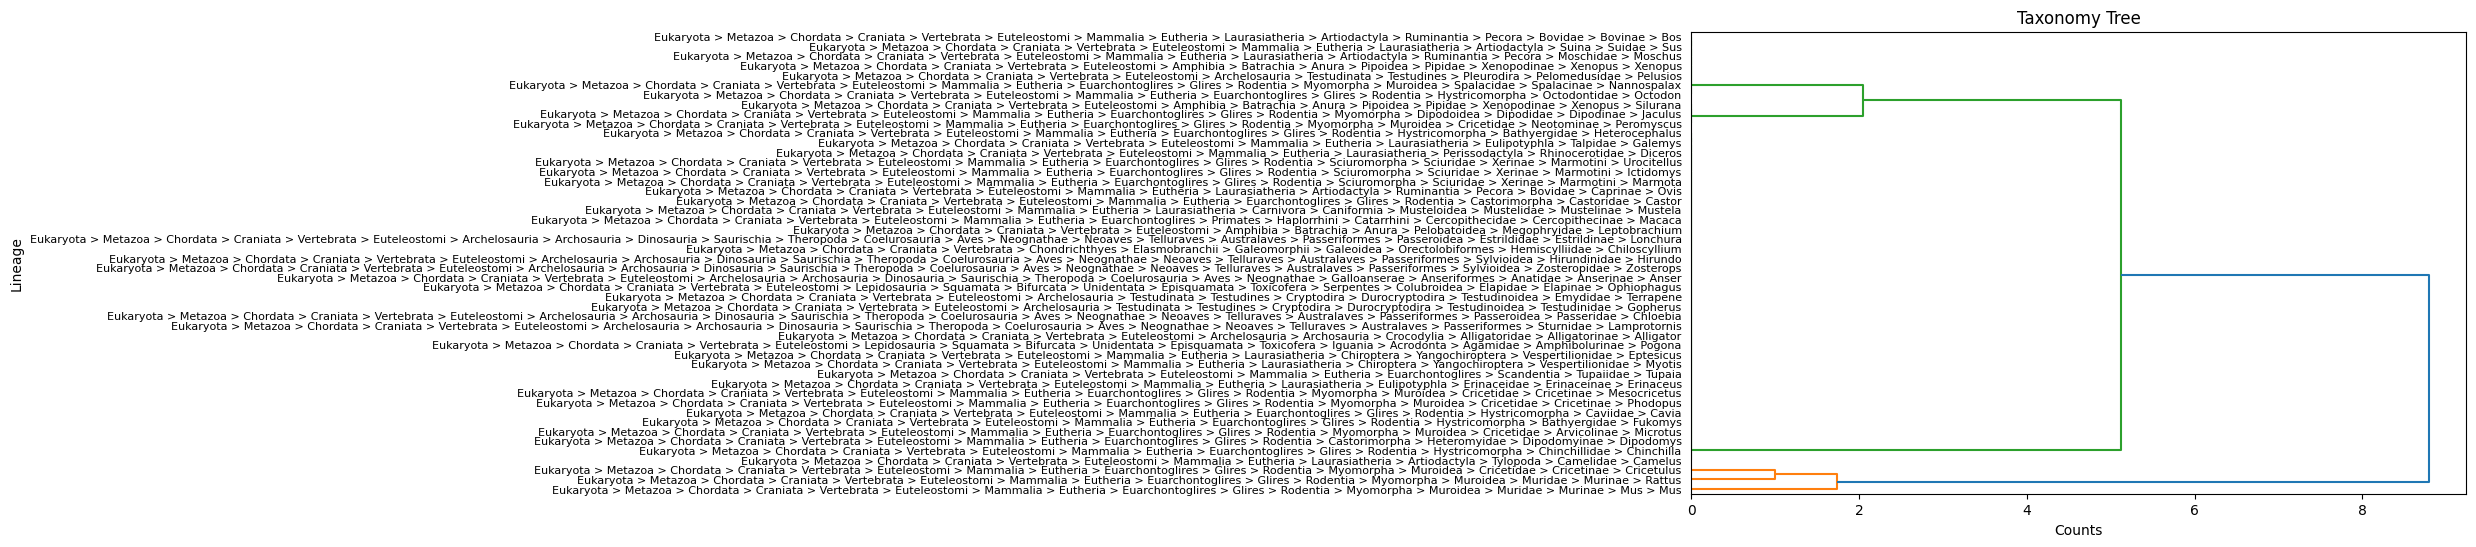

In [5]:
import pandas as pd
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Load taxonomy data
taxonomy_file = "taxonomy_info.csv"  # Replace with the correct file path
taxonomy_data = pd.read_csv(taxonomy_file)

# Ensure the "Lineage" column is processed correctly
taxonomy_data['Lineage'] = taxonomy_data['Lineage'].fillna("Unknown")

# Count occurrences of each lineage
lineage_counts = Counter(taxonomy_data['Lineage'])

# Create a matrix for hierarchical clustering
lineage_labels = list(lineage_counts.keys())
lineage_sizes = [[count] for count in lineage_counts.values()]

# Perform hierarchical clustering
Z = linkage(lineage_sizes, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=lineage_labels, orientation='right', leaf_font_size=8)
plt.title("Taxonomy Tree")
plt.xlabel("Counts")
plt.ylabel("Lineage")
plt.tight_layout()

# Save the plot
plt.savefig("tree_output.png", dpi=300)
plt.show()


### Function

1. Collect GO annotations for each protein of the family_sequences dataset (entity/dbReference type="GO" in the UniProt XML)

2. Calculate the enrichment of each term in the dataset compared to GO annotations available in the SwissProt database (you can download the entire SwissProt XML here). You can use Fisher’ exact test and verify that both two-tails and right-tail P-values (or left-tail depending on how you build the confusion matrix) are close to zero

3. Plot enriched terms in a word cloud 

4. Take into consideration the hierarchical structure of the GO ontology and report most significantly enriched branches, i.e. high level terms

5. Always report the full name of the terms and not only the GO ID

Word cloud saved as enriched_terms_wordcloud.png


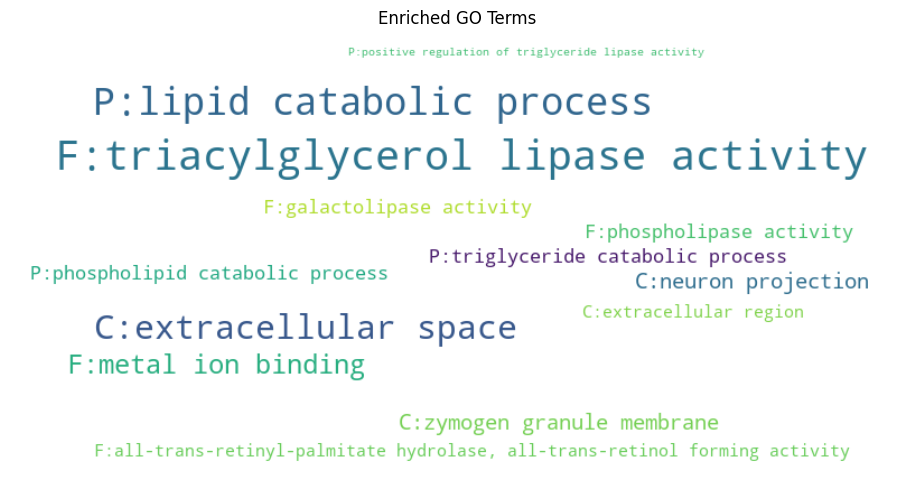

In [1]:
import requests
import xml.etree.ElementTree as ET
from scipy.stats import fisher_exact
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import numpy as np

# Step 1: Fetch GO annotations dynamically from the UniProt API
def fetch_go_annotations(protein_id):
    url = f"https://rest.uniprot.org/uniprotkb/{protein_id}.xml"
    response = requests.get(url)
    if response.status_code == 200:
        go_terms = []
        namespaces = {'ns': 'http://uniprot.org/uniprot'}
        root = ET.fromstring(response.content)
        for db_ref in root.findall(".//ns:dbReference[@type='GO']", namespaces):
            go_id = db_ref.attrib.get('id')
            term = db_ref.find("ns:property[@type='term']", namespaces)
            if go_id and term is not None:
                go_terms.append({"GO_ID": go_id, "Term": term.attrib['value']})
        return go_terms
    else:
        return []

# Step 2: Extract protein IDs from your text file
def read_protein_ids(file_path):
    with open(file_path, "r") as f:
        return [line.strip() for line in f.readlines()]

# Step 3: Fetch background GO annotations in smaller batches
def fetch_random_proteins(batch_size=100, total_proteins=500):
    url = "https://rest.uniprot.org/uniprotkb/stream?query=reviewed:true&format=list"
    response = requests.get(url)
    if response.status_code == 200:
        all_proteins = response.text.splitlines()
        selected_proteins = random.sample(all_proteins, total_proteins)
        return [selected_proteins[i:i+batch_size] for i in range(0, len(selected_proteins), batch_size)]
    else:
        return []

def fetch_background_annotations(protein_batches):
    background_annotations = {}
    for batch in protein_batches:
        for pid in batch:
            background_annotations[pid] = fetch_go_annotations(pid)
    return background_annotations

# Step 4: Flatten annotations for enrichment analysis
def flatten_annotations(annotation_dict):
    flat_terms = []
    for annotations in annotation_dict.values():
        flat_terms.extend([a["GO_ID"] for a in annotations])
    return flat_terms

# Step 5: Perform Fisher's exact test
def calculate_enrichment(go_term, family_terms, background_terms):
    family_count = family_terms.count(go_term)
    family_not = len(family_terms) - family_count
    background_count = background_terms.count(go_term)
    background_not = len(background_terms) - background_count

    contingency_table = [[family_count, background_count],
                         [family_not, background_not]]
    _, p_value = fisher_exact(contingency_table, alternative='greater')
    return p_value

# Step 6: Generate and save a word cloud for enriched terms
def plot_wordcloud(enrichment_results, annotations, output_file="enriched_terms_wordcloud.png"):
    term_names = {a["GO_ID"]: a["Term"] for ann_list in annotations.values() for a in ann_list}
    enriched_with_names = {term_names[go_id]: -np.log10(p) for go_id, p in enrichment_results.items() if go_id in term_names}
    
    if not enriched_with_names:
        print("No enriched terms found. Word cloud will not be generated.")
        return
    
    # Generate and save the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(enriched_with_names)
    wordcloud.to_file(output_file)
    print(f"Word cloud saved as {output_file}")
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Enriched GO Terms")
    plt.tight_layout()
    plt.show()

# Main Script
# Load family protein IDs
protein_ids = read_protein_ids("cleaned_protein_ids.txt")
family_annotations = {pid: fetch_go_annotations(pid) for pid in protein_ids}

# Fetch background annotations in batches
protein_batches = fetch_random_proteins(batch_size=50, total_proteins=200)
background_annotations = fetch_background_annotations(protein_batches)

# Flatten annotations for Fisher's test
family_terms = flatten_annotations(family_annotations)
background_terms = flatten_annotations(background_annotations)

# Enrichment Analysis
unique_go_terms = set(family_terms)
enrichment_results = {}
for term in unique_go_terms:
    p_value = calculate_enrichment(term, family_terms, background_terms)
    if p_value < 0.05:  # Adjust threshold if needed
        enrichment_results[term] = p_value

# Generate and save the word cloud
plot_wordcloud(enrichment_results, family_annotations)

### Motifs
1. Search significantly conserved short motifs inside your family. Use ELM classes and ProSite patterns (for ProSite consider only patterns “PA” lines, not the profiles). Make sure to consider as true matches only those that are found inside disordered regions. Disordered regions for the entire SwissProt (as defined by MobiDB-lite) are available here